# Train

In [9]:
import zipfile as zf
files = zf.ZipFile("dataset.zip",'r')
files.extractall()
files.close()

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [100]:
!cd dataset/
!rm dataset/.ipynb_checkpoints/ -r

In [104]:
data_dir = 'dataset'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.seed(0)
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
classes = trainloader.dataset.classes
print(trainloader.dataset.classes)

['recycle', 'trash']


In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(pretrained = True)
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [106]:
# for param in model.parameters():
#     param.requires_grad = False
    
# model.fc = nn.Sequential(nn.Linear(2048, 512),
                                #  nn.ReLU(),
                                #  nn.Dropout(0.2),
                                #  nn.Linear(512, 10),
                                #  nn.LogSoftmax(dim=1))
num_classes = 2
model.fc = nn.Sequential(nn.Linear(2048, num_classes),
                         nn.LogSoftmax(dim = 1))
criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [107]:
epochs = 5
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

Epoch 1/5.. Train loss: 0.355.. Test loss: 0.185.. Test accuracy: 0.941
Epoch 1/5.. Train loss: 0.104.. Test loss: 0.127.. Test accuracy: 0.959
Epoch 1/5.. Train loss: 0.104.. Test loss: 0.073.. Test accuracy: 0.980
Epoch 2/5.. Train loss: 0.054.. Test loss: 0.064.. Test accuracy: 0.978
Epoch 2/5.. Train loss: 0.034.. Test loss: 0.067.. Test accuracy: 0.975
Epoch 2/5.. Train loss: 0.033.. Test loss: 0.063.. Test accuracy: 0.979
Epoch 3/5.. Train loss: 0.011.. Test loss: 0.045.. Test accuracy: 0.990
Epoch 3/5.. Train loss: 0.005.. Test loss: 0.045.. Test accuracy: 0.982
Epoch 3/5.. Train loss: 0.011.. Test loss: 0.034.. Test accuracy: 0.986
Epoch 4/5.. Train loss: 0.035.. Test loss: 0.083.. Test accuracy: 0.969
Epoch 4/5.. Train loss: 0.016.. Test loss: 0.060.. Test accuracy: 0.978
Epoch 4/5.. Train loss: 0.011.. Test loss: 0.035.. Test accuracy: 0.988
Epoch 5/5.. Train loss: 0.009.. Test loss: 0.029.. Test accuracy: 0.992
Epoch 5/5.. Train loss: 0.006.. Test loss: 0.045.. Test accuracy

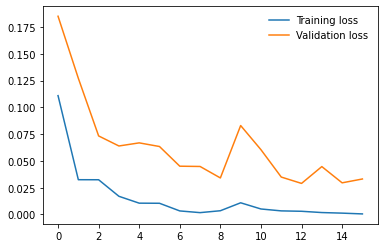

In [108]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# Test (start from here)

1. set 'Hardware accelerator' to 'GPU' in "Edit/Notebook settings"
2. load a random image for test or unzip the 'dataset.zip', including two types, recycle/trash

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
import zipfile as zf
files = zf.ZipFile("dataset.zip",'r')
files.extractall()
files.close()

In [113]:
data_dir = 'dataset'
test_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), ])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('model.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [114]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # input = Variable(image_tensor)
    input = image_tensor
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

You can set 'path' to a random test image path.

In [115]:
path = 'dataset/trash/trash101.jpg'
from PIL import Image
# img = torch.from_numpy(np.array(Image.open(path)))
image = Image.open(path)
index = predict_image(image)
# print(classes[index])
print(index)

1
